In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from nltk.tokenize import word_tokenize

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

stops = set(stopwords.words('spanish'))
from spacy.lang.es.stop_words import STOP_WORDS
stop = STOP_WORDS

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation


#Libraries for clustering
from sklearn.cluster import KMeans

import spacy
nlp = spacy.load("es_dep_news_trf")

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


In [130]:
#df = pd.read_csv('dataset_clean.csv').fillna('')
#df = df[df['label'] == ''].drop(['cluster250', 'label'], axis=1)

In [131]:
df = pd.read_excel('Productos con Data Extra.xlsx')


#Limpiar el dataset
columnas_interes = ['id_producto', 'nombre_marca', 'nombre_reciclaje', 'nombre_empresa', 'nombre_productos_clasificacion', 'nombre', 'gramos_envase', 'formato', 'unidad']
df = df[columnas_interes]
df['unidad']=df.formato.str.replace('(\d*\.\d+|\d+)',"")
df['unidad'] = df['unidad'].str.replace('X', '')
df['unidad'] = df['unidad'].str.replace('?', '')
df['unidad'] = df['unidad'].replace('Kg', 'KG')
df['unidad'] = df['unidad'].replace('G', 'GR')
df['unidad'] = df['unidad'].replace('GRGR', 'GR')
df['unidad'] = df['unidad'].replace('POTEGR', 'GR')
df['unidad'] = df['unidad'].replace('LITRO', 'LT')
df['unidad'] = df['unidad'].replace('LTLT', 'LT')
df['unidad'] = df['unidad'].replace('L', 'LT')
df['unidad'] = df['unidad'].replace('UNIDADES', 'UN')
df['unidad'] = df['unidad'].replace('UNUNIDADES', 'UN')
df['unidad'] = df['unidad'].replace('UNID', 'UN')
df['unidad'] = df['unidad'].replace('UNUN', 'UN')
df['unidad'] = df['unidad'].replace('MLML', 'ML')
df['unidad'] = df['unidad'].replace('CCCC', 'CC')
df['unidad_real'] = df['unidad']

#Obtener el nombre de las marcas
df['nombre_marca'] = df['nombre_marca'].astype(str)
df['nombre_marca'] = df['nombre_marca'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df['nombre_marca'] = df.nombre_marca.str.replace("[#,@,&,°,%,º,/,']", '')
df['nombre_marca'] = df['nombre_marca'].apply(lambda x: x.lower())
marcas = df['nombre_marca'].unique().tolist()

#Estandarizar el nombre de los productos
df['nombre'] = df['nombre'].astype(str)
df['nombre'] = df['nombre'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
df['nombre'] = df.nombre.str.replace('[#,@,&,°,%,º,/]', '')
df['nombre'] = df['nombre'].replace('lí-quido', 'líquido')

#Obtener el formato del producto
df['cantidad']=df.formato.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
df['unidad']=df.formato.str.replace('(\d*\.\d+|\d+)',"")
df['unidad'] = df['unidad'].str.replace('X', '')
df['unidad'] = df['unidad'].str.replace('?', '')
df['unidad'] = df['unidad'].replace('Kg', 'KG')
df['unidad'] = df['unidad'].replace('G', 'GR')
df['unidad'] = df['unidad'].replace('GRGR', 'GR')
df['unidad'] = df['unidad'].replace('LITRO', 'LT')
df['unidad'] = df['unidad'].replace('LTLT', 'LT')
df['unidad'] = df['unidad'].replace('L', 'LT')
df['unidad'] = df['unidad'].replace('UNIDADES', 'UN')
df['unidad'] = df['unidad'].replace('UNUN', 'UN')
df['unidad'] = df['unidad'].replace('MLML', 'ML')
df['unidad'] = df['unidad'].replace('CCCC', 'CC')
units = ['KG', 'LT', 'ML', 'GR', 'UN', 'CC']
#df = df[df['unidad'].isin(units)]

#Estandarización de elementos en base de datos
df['nombre_productos_clasificacion'] = df['nombre_productos_clasificacion'].replace('SIN DEPARTAMENTO', np.nan)
df['nombre_productos_clasificacion'] = df['nombre_productos_clasificacion'].replace('OTROS', np.nan)
df['nombre_productos_clasificacion'] = df['nombre_productos_clasificacion'].replace('LICORES, CERVEZA S Y  VINOS', 'LICORES, CERVEZAS Y  VINOS')
df['nombre_reciclaje'] = df['nombre_reciclaje'].replace('SIN SUB. CAT', np.nan)
df['nombre_reciclaje'] = df['nombre_reciclaje'].replace('OTRO', np.nan)
df['nombre_empresa'] = df['nombre_empresa'].replace('SIN ASIGNAR', np.nan)
df['nombre_marca'] = df['nombre_marca'].replace('.', np.nan)

In [132]:
def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        if len(word)>2:
            if not word.is_punct:
                lemma = word.lemma_.strip()
                if lemma:
                    if not remove_stopwords or (remove_stopwords and lemma not in stops):
                        lemmatized.append(lemma)
    return " ".join(lemmatized)

df['texto'] = df['nombre'].apply(normalize, lowercase=True, remove_stopwords=True)

In [133]:
def stem_sentence(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence = [word for word in token_words]
    return ' '.join(stem_sentence)

In [134]:
colors = ['naranja','frutilla','chocolate','vainilla','limón', 'oliva', 'manzana', 'zero', 'pera', 'color', 'collection', 'collecion', 'extra', 'pack','oregano', 'li', 'lí', 'piña', 'fruta', 'frambuesa', 'mango', 'durazno', 'especial', 'sour', 'original', 'saborizante', 'lucuma', 'caramel', 'verde', 'berries', 'tipo', 'jengibre', 'recarga', 'pisos', 'virgen', 'light', 'nido', 'cabernet', 'sauvignon', 'rojo', 'loncoleche', 'blanco', 'mineral', 'semidescremado', 'precio', 'entero', 'cat', 'natural', 'litro']
colors = colors + marcas

In [135]:
def preprocess(df_to_preprocess):
    text1 = df_to_preprocess['texto']
    #Stem and make lower case
    text3 = pd.Series([stem_sentence(x) for x in text1])
    text4 = [' '.join([x for x in string.split() if x not in colors]) for string in text3]

    #Bag of words
    vectorizer_cv = CountVectorizer(analyzer='word')
    X_cv = vectorizer_cv.fit_transform(text4)

    #Show Matrix
    #matrix = pd.concat([text1, pd.DataFrame(X_cv.toarray(), columns=vectorizer_cv.get_feature_names())], axis=1)
    #matrix.head()

    #TF-IDF (word level)
    vectorizer_wtf = TfidfVectorizer(analyzer='word')
    X_wtf = vectorizer_wtf.fit_transform(text4)

    #TF-IDF (n-gram level)
    vectorizer_ntf = TfidfVectorizer(analyzer='word',ngram_range=(1,2))
    X_ntf = vectorizer_ntf.fit_transform(text4)

    #LDA
    total = 50
    lda = LatentDirichletAllocation(n_components=total, learning_decay=0.9)
    X_lda = lda.fit(X_cv)

    return X_cv, X_wtf, X_ntf, X_lda, vectorizer_cv, vectorizer_wtf, vectorizer_ntf, text1

X_cv, X_wtf, X_ntf, X_lda, vectorizer_cv, vectorizer_wtf, vectorizer_ntf, text1 = preprocess(df)

In [136]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [137]:
#Show topics
#n_top_words = 5
#feature_names = vectorizer_cv.get_feature_names()
#plot_top_words(X_lda, feature_names, n_top_words, '')

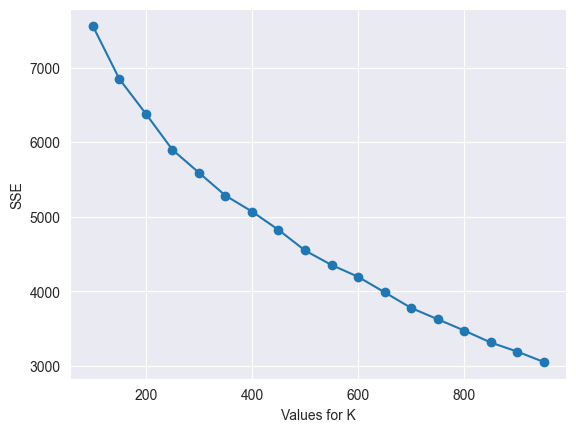

In [138]:
#Test increments of 100 clusters using elbow method
sse={}
for k in np.arange(100,1000,50):
    kmeans = KMeans(n_clusters=k, max_iter=1500).fit(X_cv)
    sse[k] = kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()), marker = 'o')
plt.xlabel('Values for K')
plt.ylabel('SSE')
plt.show();

In [205]:
def cluster_text(df_to_cluster, n_cluster):
    X_cv, X_wtf, X_ntf, X_lda, vectorizer_cv, vectorizer_wtf, vectorizer_nt,text1 = preprocess(df_to_cluster)
    kmeans_clust = KMeans(n_clusters = n_cluster)
    cluster_name = 'cluster' + str(n_cluster)
    label_name = 'label' + str(n_cluster)
    kmeans_clust.fit(X_cv)
    result = pd.concat([text1, pd.DataFrame(X_cv.toarray(), columns=vectorizer_cv.get_feature_names())],axis=1)
    result = result[:]
    result[cluster_name] = kmeans_clust.predict(X_cv)
    clusters = result[cluster_name].unique()
    labels = []
    for i in range(len(clusters)):
        subset = result[result[cluster_name] == clusters[i]]
        words = ' '.join([x for x in np.where(subset.all()!=0,subset.columns,None) if x and x!='texto' and x!=cluster_name and len(x.split()) == 1])
        labels.append(words)

    result = result[['texto', cluster_name]]
    result = result.drop_duplicates()
    labels_table = pd.DataFrame(zip(clusters,labels),columns=[cluster_name, label_name])
    df_final = pd.merge(df_to_cluster, result, on='texto', how='left')
    df_final = pd.merge(df_final, labels_table, on=cluster_name, how='left')
    df_final = df_final.drop_duplicates()
    df_final[label_name] = df_final[label_name].str.title()
    return df_final

In [206]:
df = df[['id_producto','nombre_marca','nombre_reciclaje','nombre_empresa','nombre_productos_clasificacion','nombre','gramos_envase','formato','unidad','unidad_real','cantidad','texto']]

In [207]:
cluster_list = [300]
for clust in cluster_list:
    df = cluster_text(df, clust)

,id_producto,nombre_marca,nombre_reciclaje,nombre_empresa,nombre_productos_clasificacion,nombre,gramos_envase,formato,unidad,unidad_real,cantidad,texto,cluster300,label300
0,44.0,celebrite,VIDRIO,CELEBRITE,"LICORES, CERVEZAS Y VINOS",Espumante Celebrite Extra Brut cc,800.0,NaN,NaN,NaN,NaN,espumante celebrite extra brut,114,Brut Espumante
1,55.0,viñamar,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",Viña Mar Extra Brut,800.0,NaN,NaN,NaN,NaN,viña mar extra brut,43,
2,137.0,viñamar,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",VINO ESPUMANTE EXTRA BRUT,800.0,750CC,CC,CC,750.0,vino espumante extra brut,114,Brut Espumante
3,4839.0,alto del carmen,VIDRIO,NaN,"LICORES, CERVEZAS Y VINOS",Pisco Alto del Carmen LT Alto Especial,800.0,NaN,NaN,NaN,NaN,pisco alto carmen alto especial,130,Pisco
4,14.0,mistral,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",PISCO ESPECIAL AÑEJADO EN ROBLE BOTELLA,800.0,750CC,CC,CC,750.0,pisco especial añejado roble botella,130,Pisco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,872.0,prochef,NaN,PROCHEF,NaN,ACEITE AEROSOL COCO PROCHEF GR,1.0,225GR,GR,GR,225.0,aceite aerosol coco prochef,12,Aceite
4994,873.0,prochef,NaN,PROCHEF,NaN,ACEITE AEROSOL CANOL PROCHEF GR,1.0,400GR,GR,GR,400.0,aceite aerosol canol prochef,12,Aceite
4995,874.0,prochef,NaN,PROCHEF,NaN,SPRAY OLIVA LIGHT. PROCHEF GR,1.0,225GR,GR,GR,225.0,spray oliva light prochef,43,
4996,738.0,olivodeplata,NaN,OLIVODEPLATA,NaN,ACEITE OLIVA EXTRA VIRGEN OLIVODEPLATA LT,1.0,1LT,LT,LT,1.0,aceite oliva extra virgen olivodeplata,12,Aceite


In [209]:
df_rezagados = df[df['label300'] == '']
df_rezagados.reset_index(drop=True, inplace=True)
cluster_list = [250]
for clust in cluster_list:
    df_rezagados = cluster_text(df_rezagados, clust)
df_rezagados

,id_producto,nombre_marca,nombre_reciclaje,nombre_empresa,nombre_productos_clasificacion,nombre,gramos_envase,formato,unidad,unidad_real,cantidad,texto,cluster300,label300,cluster250,label250
0,55.0,viñamar,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",Viña Mar Extra Brut,800.0,NaN,NaN,NaN,NaN,viña mar extra brut,43,,167,Brut Viña
1,2667.0,bombay,NaN,NaN,"LICORES, CERVEZAS Y VINOS",Gin Star Of Bombay Gl,700.0,SAPHIRE,SAPHIRE,SAPHIRE,NaN,gin star bombay,43,,181,Gin
2,2671.0,bombay,NaN,NaN,"LICORES, CERVEZAS Y VINOS",Gin Bombay Saphire Gl,700.0,SAPHIRE,SAPHIRE,SAPHIRE,NaN,gin bombay saphire,43,,181,Gin
3,2740.0,tanqueray,NaN,NaN,"LICORES, CERVEZAS Y VINOS",Gin Tanqueray . Gl,700.0,750ML,ML,ML,750.0,gin tanqueray,43,,181,Gin
4,2741.0,larios,NaN,NaN,"LICORES, CERVEZAS Y VINOS",Gin dry .,700.0,UN,UN,UN,NaN,gin dry,43,,181,Gin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1196,841.0,colacao,NaN,COLACAO,NaN,COLA CAO NOIR COLACAO GR,1.0,300GR,GR,GR,300.0,cola cao noir colacao,43,,9,Cao
1197,842.0,colacao,NaN,COLACAO,NaN,COLA CAO MOCCA COLACAO GR,1.0,270GR,GR,GR,270.0,cola cao mocca colacao,43,,9,Cao
1198,868.0,bellaholandesa,NaN,BELLAHOLANDESA,NaN,EVAPORADA B.H. BELLAHOLANDESA GR,1.0,405GR,GR,GR,405.0,evaporado b.h bellaholandesa,43,,10,
1199,874.0,prochef,NaN,PROCHEF,NaN,SPRAY OLIVA LIGHT. PROCHEF GR,1.0,225GR,GR,GR,225.0,spray oliva light prochef,43,,131,Spray


In [212]:
df_rezagados2 = df_rezagados[df_rezagados['label250'] == '']
df_rezagados2.reset_index(drop=True, inplace=True)
cluster_list = [350]
for clust in cluster_list:
    df_rezagados2 = cluster_text(df_rezagados2, clust)
df_rezagados2

,id_producto,nombre_marca,nombre_reciclaje,nombre_empresa,nombre_productos_clasificacion,nombre,gramos_envase,formato,unidad,unidad_real,cantidad,texto,cluster300,label300,cluster250,label250,cluster350,label350
0,4815.0,santa carolina,VIDRIO,NaN,"LICORES, CERVEZAS Y VINOS",Carmenere Gran Reserva cc,525.0,NaN,NaN,NaN,NaN,carmenere gran reserva,43,,10,,192,Carmenere
1,4904.0,puyehue,VIDRIO,NaN,"BEBIDAS, AGUAS Y JUGOS",Agua Mineral Natural PUYEHUE Gasificada ml,215.0,NaN,NaN,NaN,NaN,agua mineral natural puyehue gasificado,43,,10,,295,Gasificado
2,4997.0,nan,NaN,NaN,NaN,vital vidrio ml,190.0,NaN,NaN,NaN,NaN,vital vidrio,43,,10,,212,Vidrio
3,625.0,colun,NaN,COLUN,NaN,L CAP LIGHT PRISMA COLUN CC,180.0,330CC,CC,CC,330.0,cap light prisma colun,43,,10,,186,Cap
4,1517.0,kasteel,NaN,NaN,"LICORES, CERVEZAS Y VINOS",Ceverveza Botella,180.0,330ML,ML,ML,330.0,ceverveza botella,43,,10,,267,Botella Ceverveza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,832.0,bravocream,NaN,BRAVOCREAM,NaN,BRAVO CREM ML BRAVOCREAM ML,1.0,200ML,ML,ML,200.0,bravo crem bravocream,43,,10,,289,Bravo Crem
613,834.0,isolabio,NaN,ISOLABIO,NaN,CREMAVENA ORG ISOLABIO ML,1.0,200ML,ML,ML,200.0,cremavena org isolabio,43,,10,,206,Cremavena Org
614,835.0,scotti,NaN,SCOTTI,NaN,ALIM LIQUIDO AVENA SCOTTI GR,1.0,1GR,GR,GR,1.0,alim liquido avena scotti,43,,10,,144,Alim Avena Liquido
615,868.0,bellaholandesa,NaN,BELLAHOLANDESA,NaN,EVAPORADA B.H. BELLAHOLANDESA GR,1.0,405GR,GR,GR,405.0,evaporado b.h bellaholandesa,43,,10,,301,Evaporado


In [142]:
df['unidad_real']=df.formato.str.replace('(\d*\.\d+|\d+)',"")
df['unidad_real'] = df['unidad_real'].str.replace('X', '')
df['unidad_real'] = df['unidad_real'].str.replace('?', '')
df['unidad_real'] = df['unidad_real'].replace('Kg', 'KG')
df['unidad_real'] = df['unidad_real'].replace('G', 'GR')
df['unidad_real'] = df['unidad_real'].replace('GRGR', 'GR')
df['unidad_real'] = df['unidad_real'].replace('POTEGR', 'GR')
df['unidad_real'] = df['unidad_real'].replace('LITRO', 'LT')
df['unidad_real'] = df['unidad_real'].replace('LTLT', 'LT')
df['unidad_real'] = df['unidad_real'].replace('L', 'LT')
df['unidad_real'] = df['unidad_real'].replace('UNIDADES', 'UN')
df['unidad_real'] = df['unidad_real'].replace('UNUNIDADES', 'UN')
df['unidad_real'] = df['unidad_real'].replace('UNID', 'UN')
df['unidad_real'] = df['unidad_real'].replace('UNUN', 'UN')
df['unidad_real'] = df['unidad_real'].replace('MLML', 'ML')
df['unidad_real'] = df['unidad_real'].replace('CCCC', 'CC')

In [147]:
df['label'] = df['label'].str.title()
df_rezagados = df[df['label'] == '']
df_rezagados

,id_producto,nombre_marca,nombre_reciclaje,nombre_empresa,nombre_productos_clasificacion,nombre,gramos_envase,formato,unidad,unidad_real,cantidad,texto,cluster500,label
1,55.0,viñamar,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",Viña Mar Extra Brut,800.0,NaN,NaN,NaN,NaN,viña mar extra brut,8,
135,4854.0,nan,NaN,NaN,"LICORES, CERVEZAS Y VINOS",Aperol aperitivo dal campari ml neto,549.0,NaN,NaN,NaN,NaN,aperol aperitivo dal campari neto,8,
137,4815.0,santa carolina,VIDRIO,NaN,"LICORES, CERVEZAS Y VINOS",Carmenere Gran Reserva cc,525.0,NaN,NaN,NaN,NaN,carmenere gran reserva,8,
349,4848.0,kunstmann,NaN,CCU,"LICORES, CERVEZAS Y VINOS",Kunstmann Gran Torobayo Valdivia cc netos. a...,393.0,NaN,NaN,NaN,NaN,kunstmann gran torobayo valdivia neto alcohol,8,
357,4904.0,puyehue,VIDRIO,NaN,"BEBIDAS, AGUAS Y JUGOS",Agua Mineral Natural PUYEHUE Gasificada ml,215.0,NaN,NaN,NaN,NaN,agua mineral natural puyehue gasificado,8,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4969,833.0,isolabio,NaN,ISOLABIO,NaN,CREM COCO ORG ISOLABIO ML,1.0,200ML,ML,ML,200.0,crem coco org isolabio,8,
4970,834.0,isolabio,NaN,ISOLABIO,NaN,CREMAVENA ORG ISOLABIO ML,1.0,200ML,ML,ML,200.0,cremavena org isolabio,8,
4971,835.0,scotti,NaN,SCOTTI,NaN,ALIM LIQUIDO AVENA SCOTTI GR,1.0,1GR,GR,GR,1.0,alim liquido avena scotti,8,
4989,868.0,bellaholandesa,NaN,BELLAHOLANDESA,NaN,EVAPORADA B.H. BELLAHOLANDESA GR,1.0,405GR,GR,GR,405.0,evaporado b.h bellaholandesa,8,


In [235]:
df1 = df[df['label300']!='']
df2 = df_rezagados[df_rezagados['label250']!='']
df3 = df_rezagados2

,id_producto,nombre_marca,nombre_reciclaje,nombre_empresa,nombre_productos_clasificacion,nombre,gramos_envase,formato,unidad,unidad_real,cantidad,texto,cluster300,label300
0,44.0,celebrite,VIDRIO,CELEBRITE,"LICORES, CERVEZAS Y VINOS",Espumante Celebrite Extra Brut cc,800.0,NaN,NaN,NaN,NaN,espumante celebrite extra brut,114,Brut Espumante
2,137.0,viñamar,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",VINO ESPUMANTE EXTRA BRUT,800.0,750CC,CC,CC,750.0,vino espumante extra brut,114,Brut Espumante
3,4839.0,alto del carmen,VIDRIO,NaN,"LICORES, CERVEZAS Y VINOS",Pisco Alto del Carmen LT Alto Especial,800.0,NaN,NaN,NaN,NaN,pisco alto carmen alto especial,130,Pisco
4,14.0,mistral,VIDRIO,CCU,"LICORES, CERVEZAS Y VINOS",PISCO ESPECIAL AÑEJADO EN ROBLE BOTELLA,800.0,750CC,CC,CC,750.0,pisco especial añejado roble botella,130,Pisco
5,1566.0,corona,NaN,CORONA,"LICORES, CERVEZAS Y VINOS",CERVEZA Corona Cc,800.0,INDIVIDUAL,INDIVIDUAL,INDIVIDUAL,NaN,cerveza corona,6,Cerveza
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4991,870.0,grolsch,NaN,GROLSCH,NaN,CERVEZA UN G GROLSCH UN,1.0,6UN,UN,UN,6.0,cerveza grolsch,6,Cerveza
4992,871.0,heineken,NaN,CCU,NaN,CERVEZA CERO U G HEINEKEN UN,1.0,6UN,UN,UN,6.0,cerveza cero heineken,6,Cerveza
4993,872.0,prochef,NaN,PROCHEF,NaN,ACEITE AEROSOL COCO PROCHEF GR,1.0,225GR,GR,GR,225.0,aceite aerosol coco prochef,12,Aceite
4994,873.0,prochef,NaN,PROCHEF,NaN,ACEITE AEROSOL CANOL PROCHEF GR,1.0,400GR,GR,GR,400.0,aceite aerosol canol prochef,12,Aceite


In [238]:
dict1 = {'cluster300':'cluster', 'label300':'label'}
dict2 = {'label250':'label'}
dict3 = {'label350':'label'}

In [239]:
df1.rename(columns=dict1, inplace=True)
df2.rename(columns=dict2, inplace=True)
df3.rename(columns=dict3, inplace=True)

In [240]:
df1 = df1[['id_producto', 'label']]
df2 = df2[['id_producto', 'label']]
df3 = df3[['id_producto', 'label']]

In [248]:
df_aux = pd.concat([df1,df2,df3], axis=0)
df = pd.merge(df, df_aux, on='id_producto', how='left')

In [249]:
df.to_csv('dataset_clean.csv', index=False, encoding='utf-8')